In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device being used: {device}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.10.0+cu130
CUDA available: True
CUDA version: 13.0
Device being used: cuda
GPU name: NVIDIA GeForce RTX 4080 Laptop GPU
GPU memory: 12.88 GB


In [2]:
ticker = '^GSPC'
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2026-01-26,6950.229980,6964.660156,6921.600098,6923.229980,4968050000
2026-01-27,6978.600098,6988.819824,6958.830078,6965.959961,5331720000


<Axes: xlabel='Date'>

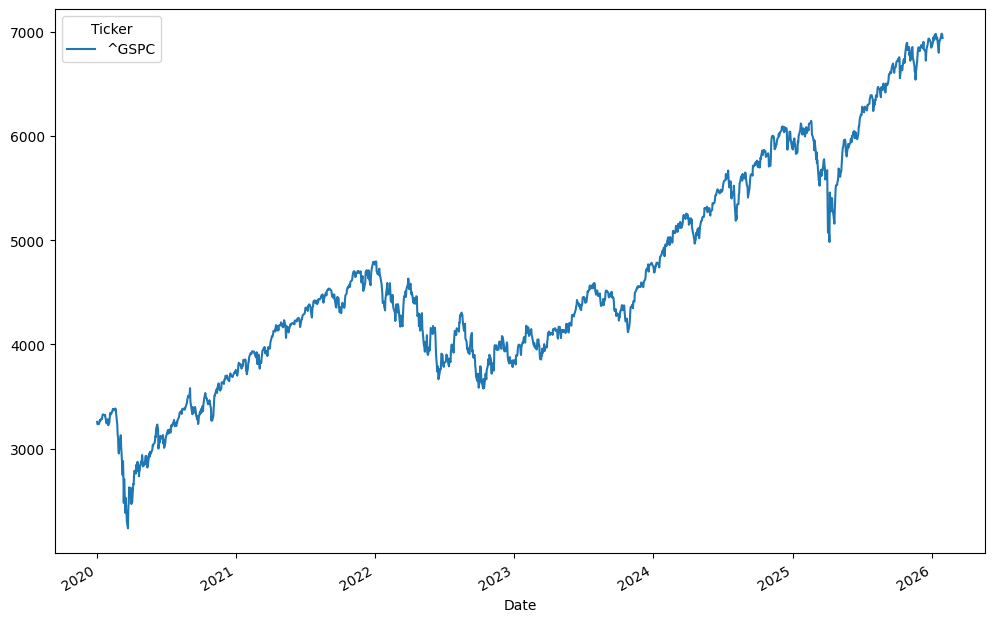

In [4]:
df.Close.plot(figsize=(12,8))

In [5]:
scaler = StandardScaler()
scaler.fit(df['Close'].values.reshape(-1, 1))

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [6]:
df.Close

Ticker,^GSPC
Date,
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049
...,...
2026-01-26,6950.229980
2026-01-27,6978.600098
2026-01-28,6978.029785


In [7]:
seq_length = 120
data = []

for i in range(len(df) - seq_length):
    sequence = df.Close[i:i+seq_length].values.reshape(-1, 1)
    scaled_sequence = scaler.transform(sequence)
    data.append(scaled_sequence)
    
data = np.array(data)

In [8]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [9]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [10]:
model = PredictionModel(input_dim=1, hidden_dim=64, num_layers=3, output_dim=1, dropout=0.2).to(device)

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 1000

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, Y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0 0.40818727016448975
25 0.07492765039205551
50 0.01011727750301361
75 0.007110272534191608
100 0.006555560976266861
125 0.006124428939074278
150 0.005733456928282976
175 0.005419430788606405
200 0.005171503406018019
225 0.004943584557622671
250 0.004726402461528778
275 0.0045174164697527885
300 0.004315584432333708
325 0.004119202960282564
350 0.00392701243981719
375 0.0037345595192164183
400 0.0035366674419492483
425 0.003329339437186718
450 0.0031409801449626684
475 0.002966953907161951
500 0.0028368746861815453
525 0.002676217583939433
550 0.002629911992698908
575 0.002492958214133978
600 0.0023742783814668655
625 0.002259356901049614
650 0.0030688601545989513
675 0.002199843293055892
700 0.0020573062356561422
725 0.0019736061803996563
750 0.0019063540967181325
775 0.0018524103797972202
800 0.0049617406912148
825 0.001858734991401434
850 0.0018097679130733013
875 0.0017720279283821583
900 0.0017512274207547307
925 0.001738984719850123
950 0.0017307677771896124
975 0.001726227230392

In [13]:
model.eval()

y_train_pred = model(X_train)
y_test_pred = model(X_test)

y_train_pred = y_train_pred.detach().cpu().numpy()
y_train = Y_train.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
y_test = Y_test.detach().cpu().numpy()

y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

In [14]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [15]:
train_rmse

4422.96142578125

In [16]:
test_rmse

81.24417877197266

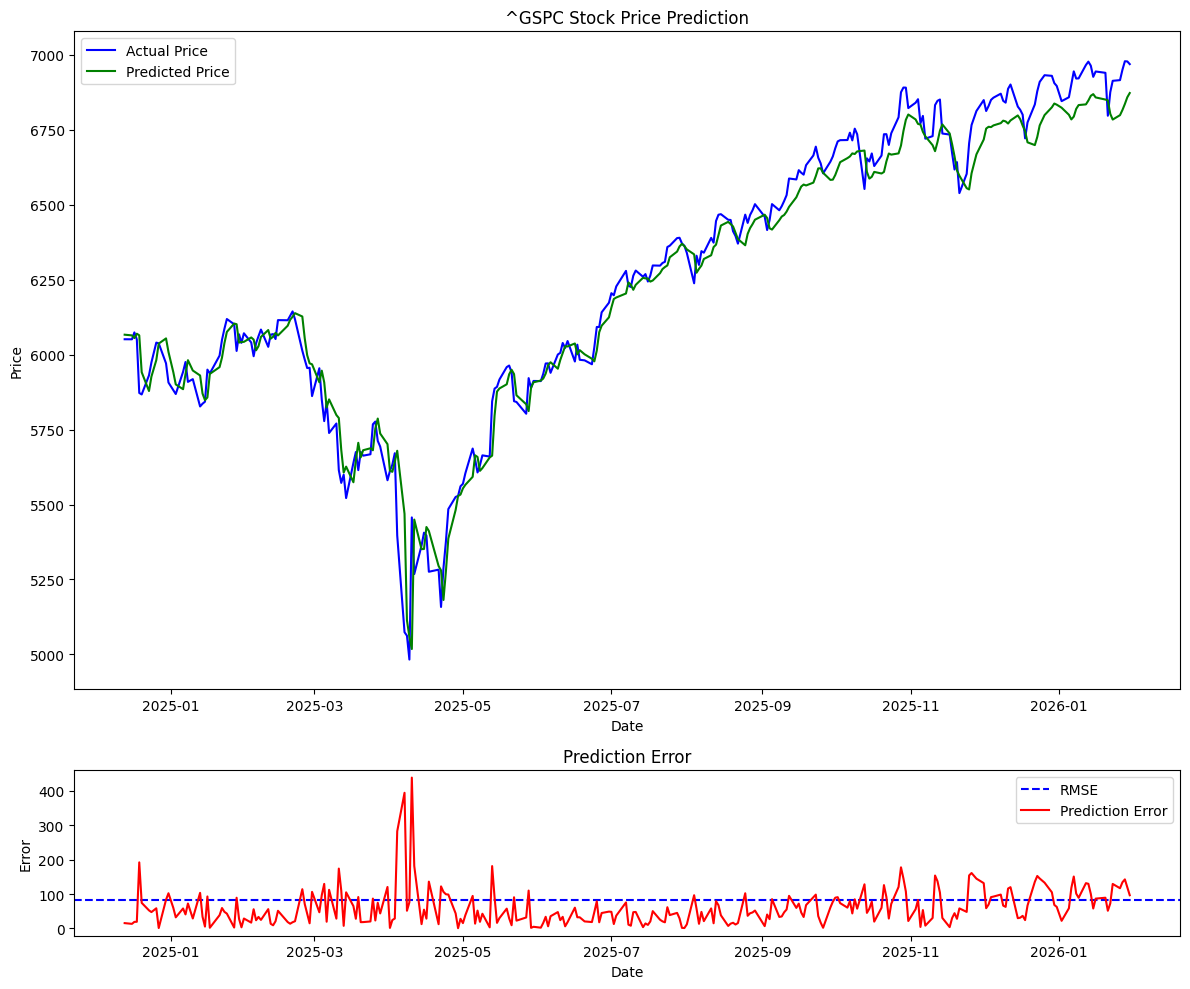

In [17]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()